In [14]:
import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)-9s %(levelname)-8s: %(message)s',
    datefmt='%I:%M:%S')

# Enable logging at INFO level
logging.getLogger().setLevel(logging.INFO)
# Comment the follwing line to disable devlib debugging statements
# logging.getLogger('ssh').setLevel(logging.DEBUG)

In [15]:
# Generate plots inline
%pylab inline

import json
import os

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['load']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Test environment setup

In [16]:
# Setup a target configuration
androidsdk_path=os.path.join(os.getcwd(), "../../../android-sdk")
my_target_conf = {
    
    "platform"    : 'android',
    "board"       : "hikey960",
    "device" : "0123456789ABCDEF",
    
    "ANDROID_HOME" : androidsdk_path,
    "rtapp-calib" : {"0": 302, "1": 302, "2": 304, "3": 304, "4": 136, "5": 137, "6": 136, "7": 136},

     "emeter" : {
        "instrument" : "acme",
        "conf" : {
            # Absolute path to the iio-capture binary on the host
            'iio-capture' : '/usr/bin/iio-capture',
            # Default host name of the BeagleBone Black
            'ip_address'     : '10.65.34.1',
        },
        "channel_map" : {
            "Device0" : 0, # iio:device0
            "Device1" : 1, # iio:device0
        }
    },

    # Binary tools required to run this experiment
    # These tools must be present in the tools/ folder for the architecture
    "tools"   : ['rt-app', 'taskset', 'trace-cmd'],

            
    # List of additional devlib modules to install 
    "modules" : ['cgroups', 'bl', 'cpufreq'],

    # Define devlib module to load
    #"modules"     : [
    #    'bl',           # enable big.LITTLE support
    #    'cpufreq'       # enable CPUFreq support
    #],

    # Account to access the remote target
    "host"        : '10.169.36.55',
    "username"    : 'root',
    "password"    : '',



}

# Setup the required Test Environment supports
my_tests_conf = {
    
    # Binary tools required to run this experiment
    # These tools must be present in the tools/ folder for the architecture
    #"tools"   : ['rt-app', 'taskset', 'trace-cmd'],
    
    # FTrace events end buffer configuration
    "ftrace"  : {
         "events" : [
             "sched_load_avg_cpu",
             "sched_load_avg_task",
             "sched_switch",
             "cpu_frequency"
             
         ],
         "buffsize" : 10240
    },

    "results_dir" : "simple_rtapp",
}

In [17]:
# Support to access the remote target
import devlib
from env import TestEnv

# Initialize a test environment using:
# the provided target configuration (my_target_conf)
# the provided test configuration   (my_test_conf)
te = TestEnv(target_conf=my_target_conf, test_conf=my_tests_conf)
target = te.target

03:35:59  INFO    : Using base path: /home/steven/lisa/lisa-github
03:35:59  INFO    : Loading custom (inline) target configuration
03:35:59  INFO    : Loading custom (inline) test configuration
03:35:59  INFO    : External tools using:
03:35:59  INFO    :    ANDROID_HOME: /home/steven/lisa/lisa-github/ipynb/workshop/../../../android-sdk
03:35:59  INFO    :    CATAPULT_HOME: /home/steven/lisa/lisa-github/tools/catapult
03:35:59  INFO    : Devlib modules to load: ['bl', 'cpuidle', 'cpufreq', 'cgroups']
03:35:59  INFO    : Connecting Android target [0123456789ABCDEF]
03:35:59  INFO    : Connection settings:
03:35:59  INFO    :    {'device': '0123456789ABCDEF'}
03:36:00  INFO    : Initializing target workdir:
03:36:00  INFO    :    /data/local/tmp/devlib-target
03:36:00  INFO    : Available controllers:
03:36:01  INFO    :   cpuset       : /data/local/tmp/devlib-target/cgroups/devlib_cgh5
03:36:01  INFO    :   cpu          : /data/local/tmp/devlib-target/cgroups/devlib_cgh4
03:36:01  INFO

# Workload configuration

In [18]:
# Support to configure and run RTApp based workloads
from wlgen import RTA, Periodic, Ramp

# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp.conf(
    # 1. generate a "profile based" set of tasks
    kind='profile',
    
    # 2. define the "profile" of each task
    params={
        
        # 3. PERIODIC task with
        'task_p20': Periodic(
            period_ms=100,         # period
            duty_cycle_pct=20,     # duty cycle
            duration_s=5,          # duration    
            cpus='0'               # pinned on CPU0
        ).get(),
        
        # 4. RAMP task (i.e. increasing load) with
        'task_r20_5-60': Ramp(
            start_pct=5,           # intial load
            end_pct=65,            # end load
            delta_pct=20,          # load % increase...
            time_s=1,              # ... every 1[s]
            # pinned on last CPU of the target
            cpus=str(len(target.core_names)-1)
        ).get(),
    },
    
    # 4. use this folder for task logfiles
    run_dir=target.working_directory
    
);

03:36:06  INFO    : Setup new workload simple
03:36:06  INFO    : Workload duration defined by longest task
03:36:06  INFO    : Default policy: SCHED_OTHER
03:36:06  INFO    : ------------------------
03:36:06  INFO    : task [task_p20], sched: using default policy
03:36:06  INFO    :  | loops count: 1
03:36:06  INFO    : + phase_000001: duration 5.000000 [s] (50 loops)
03:36:06  INFO    : |  period   100000 [us], duty_cycle  20 %
03:36:06  INFO    : |  run_time  20000 [us], sleep_time  80000 [us]
03:36:06  INFO    : |  CPUs affinity: 0
03:36:06  INFO    : ------------------------
03:36:06  INFO    : task [task_r20_5-60], sched: using default policy
03:36:06  INFO    :  | loops count: 1
03:36:06  INFO    : + phase_000001: duration 1.000000 [s] (10 loops)
03:36:06  INFO    : |  period   100000 [us], duty_cycle   5 %
03:36:06  INFO    : |  run_time   5000 [us], sleep_time  95000 [us]
03:36:06  INFO    : |  CPUs affinity: 7
03:36:06  INFO    : + phase_000002: duration 1.000000 [s] (10 loo

# Workload execution

In [19]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

03:36:06  INFO    : #### Setup FTrace
03:36:10  INFO    : #### Start energy sampling
03:36:11  INFO    : #### Start RTApp execution
03:36:11  INFO    : Workload execution START:
03:36:11  INFO    :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple_00.json 2>&1
03:36:18  INFO    : #### Read energy consumption: /home/steven/lisa/lisa-github/results/20180817_153559/energy.json
03:36:18  ERROR   : /usr/bin/iio-capture terminated for Device1 (iio:device1)
03:36:18  ERROR   : [Unable to create IIO context
]
03:36:18  ERROR   : /usr/bin/iio-capture terminated for Device0 (iio:device0)
03:36:18  ERROR   : [Unable to create IIO context
]
03:36:18  INFO    : #### Stop FTrace
03:36:18  INFO    : #### Save FTrace: /home/steven/lisa/lisa-github/results/20180817_153559/trace.dat
03:36:20  INFO    : #### Save platform description: /home/steven/lisa/lisa-github/results/20180817_153559/platform.json


# Collected results

In [20]:
# All data are produced in the output folder defined by the TestEnv module
logging.info('Content of the output folder %s', te.res_dir)
!ls -la {te.res_dir}

03:36:20  INFO    : Content of the output folder /home/steven/lisa/lisa-github/results/20180817_153559


total 9908
drwxrwxr-x 1 steven steven      242  8月 17 15:36 .
drwxrwxr-x 1 steven steven     1950  8月 17 15:35 ..
-rw-rw-r-- 1 steven steven        2  8月 17 15:36 energy.json
-rw-rw-r-- 1 steven steven        2  8月 17 15:36 energy_stats.json
-rw-rw-r-- 1 steven steven      307  8月 17 15:36 output.log
-rw-rw-r-- 1 steven steven     1526  8月 17 15:36 platform.json
-rw-r--r-- 1 steven steven     6360  8月 17 15:36 rt-app-task_p20-0.log
-rw-r--r-- 1 steven steven     5120  8月 17 15:36 rt-app-task_r20_5-60-1.log
-rw-r--r-- 1 steven steven     2123  8月 17 15:36 simple_00.json
-rw-r--r-- 1 steven steven 10108928  8月 17 15:36 trace.dat


In [21]:
!cat {te.res_dir}/rt-app-task_p20-0.log

# Policy : SCHED_OTHER priority : 0
#idx     perf      run   period           start             end          rel_st      slack c_duration   c_period     wu_lat
   0   147058    52009    99250       343692366       343791616            3017      47142      20000     100000         85
   0   147058    56600   235197       343791631       344026829          102282      43292      20000     100000     135298
   0   147058    66186    66193       344026845       344093038          337496    -101508      20000     100000          0
   0   147058   848779   848786       344093053       344941838          403704    -748799      20000     100000          0
   0   147058    45802   100315       344941854       345042169         1252505      54179      20000     100000        329
   0   147058    59102    99949       345042187       345142137         1352839      40546      20000     100000        298
   0   147058    58786    99784       345142146       345241930         1452797      40902      

In [22]:
# Inspect the JSON file used to run the application
with open('{}/simple_00.json'.format(te.res_dir), 'r') as fh:
    rtapp_json = json.load(fh, )
logging.info('Generated RTApp JSON file:')
print json.dumps(rtapp_json, indent=4, sort_keys=True)

03:36:21  INFO    : Generated RTApp JSON file:


{
    "global": {
        "calibration": 136, 
        "default_policy": "SCHED_OTHER", 
        "duration": -1, 
        "logdir": "/data/local/tmp/devlib-target"
    }, 
    "tasks": {
        "task_p20": {
            "loop": 1, 
            "phases": {
                "p000001": {
                    "cpus": [
                        0
                    ], 
                    "loop": 50, 
                    "run": 20000, 
                    "timer": {
                        "period": 100000, 
                        "ref": "task_p20"
                    }
                }
            }, 
            "policy": "SCHED_OTHER"
        }, 
        "task_r20_5-60": {
            "loop": 1, 
            "phases": {
                "p000001": {
                    "cpus": [
                        7
                    ], 
                    "loop": 10, 
                    "run": 5000, 
                    "timer": {
                        "period": 100000, 
                     

In [23]:
# Dump the energy measured for the LITTLE and big clusters
logging.info('Energy: %s', nrg_report.report_file)
print json.dumps(nrg_report.channels, indent=4, sort_keys=True)

03:36:21  INFO    : Energy: /home/steven/lisa/lisa-github/results/20180817_153559/energy.json


{}


In [24]:
# Dump the platform descriptor, which could be useful for further analysis
# of the generated results
logging.info('Platform description: %s', plt_file)
print json.dumps(plt, indent=4, sort_keys=True)

03:36:21  INFO    : Platform description: /home/steven/lisa/lisa-github/results/20180817_153559/platform.json


{
    "abi": "arm64", 
    "clusters": {
        "big": [
            4, 
            5, 
            6, 
            7
        ], 
        "little": [
            0, 
            1, 
            2, 
            3
        ]
    }, 
    "cpus_count": 8, 
    "freqs": {
        "big": [
            903000, 
            1421000, 
            1805000, 
            2112000, 
            2362000
        ], 
        "little": [
            533000, 
            999000, 
            1402000, 
            1709000, 
            1844000
        ]
    }, 
    "kernel": {
        "major": 9, 
        "minor": 69, 
        "parts": [
            4, 
            9, 
            69
        ], 
        "rc": null, 
        "release": "4.9.69-02266-g37ec37f", 
        "sha1": "37ec37f", 
        "version": "19 SMP PREEMPT Mon Dec 18 13:59:57 CST 2017", 
        "version_number": 4
    }, 
    "nrg_model": {
        "big": {
            "cluster": {
                "nrg_max": 433
            }, 
         

# Trace inspection

In [25]:
# Suport for FTrace events parsing and visualization
import trappy

# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

In [26]:
my_events = [
    "sched_load_avg_cpu",
    "sched_load_avg_task",
    "cpu_frequency",
    "cpu_capacity"
]

ftrace = trappy.FTrace(
    name="PandasExamples",
    path=trace_file,
    scope='custom',
    events=my_events,
    window=(0,None))


my_signals = [
    'sched_load_avg_task:util_avg',
#     'sched_load_avg_cpu:util_cpu'
]

# These two paramatere are passed to the LinePlot call as long with the
# TRAPpy FTrace object
trappy.ILinePlot(
    
    # FTrace object
    ftrace,
    
    # Signals to be plotted
    signals=my_signals,
    
    # Generate one plot for each value of the specified column
    pivot='pid',
    
    # Generate only plots which satisfy these filters
    filters = {
       'comm' : 'task_r20_5-60'
    
    },
    
    # Formatting style
    drawstyle='steps-post',
    marker = '+'

).view()

""
""


# RTApp task performance plots

03:36:37  INFO    : PerfIndex, Task [task_p20] avg: 0.28, std: 1.43
03:36:37  INFO    : PerfIndex, Task [task_r20_5-60] avg: 0.83, std: 0.22


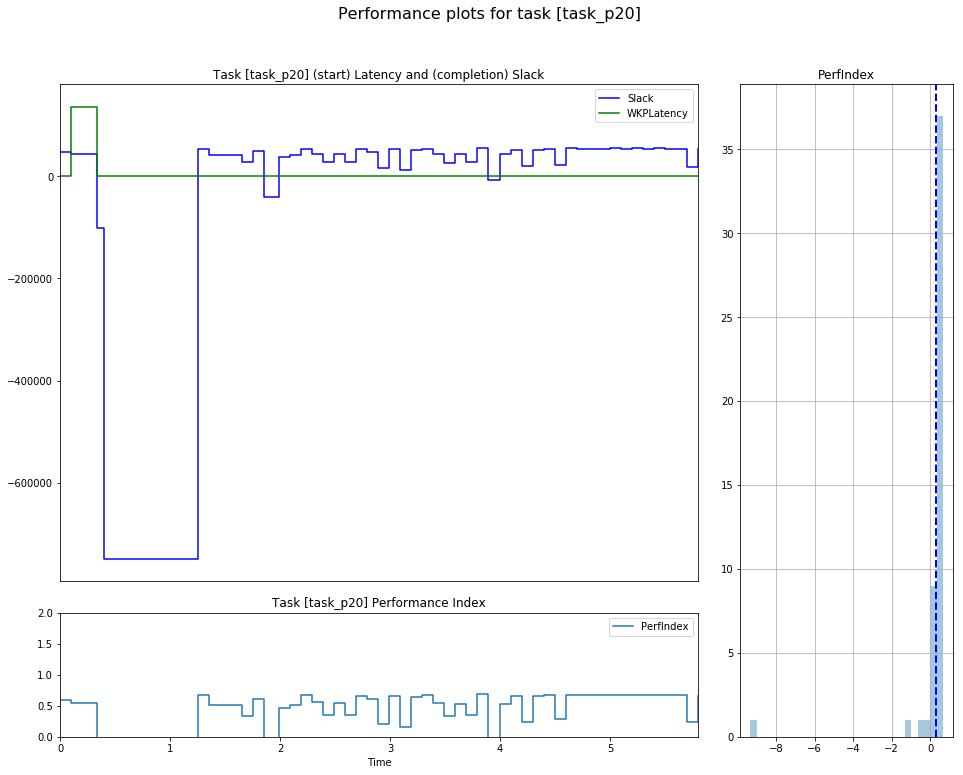

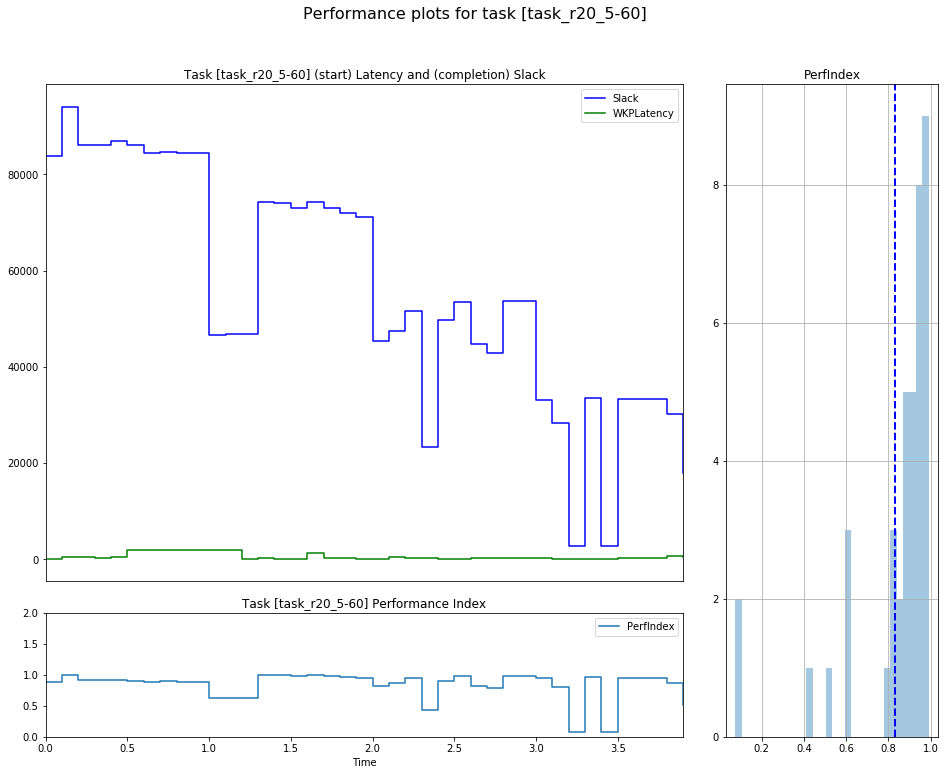

In [27]:
# Support for performance analysis of RTApp workloads
from perf_analysis import PerfAnalysis

# Parse the RT-App generate log files to compute performance metrics
pa = PerfAnalysis(te.res_dir)

# For each task which has generated a logfile, plot  its performance metrics
for task in pa.tasks():
    pa.plotPerf(task, "Performance plots for task [{}] ".format(task))

# PELT

In [28]:
import math
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [29]:
Y=pow(0.5,(1.0/32))
print Y

0.978572062088


In [30]:
Y=0.978572
y_inv=(pow(2,32) - 1) * Y

In [31]:
load = 0
df=pd.DataFrame(columns=['load'])
for i in range(-1,348):
    load = int((load * y_inv)/pow(2,32)) + 1024
    df.loc[i, 'load']=load
    print "{} load {}".format(i, load)

-1 load 1024
0 load 2026
1 load 3006
2 load 3965
3 load 4904
4 load 5822
5 load 6721
6 load 7600
7 load 8461
8 load 9303
9 load 10127
10 load 10933
11 load 11722
12 load 12494
13 load 13250
14 load 13990
15 load 14714
16 load 15422
17 load 16115
18 load 16793
19 load 17457
20 load 18106
21 load 18742
22 load 19364
23 load 19973
24 load 20569
25 load 21152
26 load 21722
27 load 22280
28 load 22826
29 load 23360
30 load 23883
31 load 24395
32 load 24896
33 load 25386
34 load 25866
35 load 26335
36 load 26794
37 load 27243
38 load 27683
39 load 28113
40 load 28534
41 load 28946
42 load 29349
43 load 29744
44 load 30130
45 load 30508
46 load 30878
47 load 31240
48 load 31594
49 load 31941
50 load 32280
51 load 32612
52 load 32937
53 load 33255
54 load 33566
55 load 33870
56 load 34168
57 load 34459
58 load 34744
59 load 35023
60 load 35296
61 load 35563
62 load 35824
63 load 36080
64 load 36330
65 load 36575
66 load 36815
67 load 37050
68 load 37280
69 load 37505
70 load 37725
71 load 3794

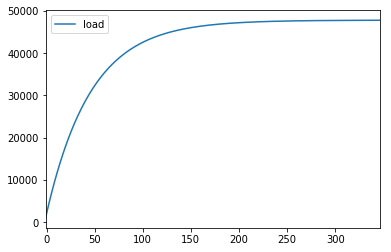

In [32]:
df.plot()